In [1]:
# Running on GPU?

import setGPU

setGPU: Setting GPU to: 0


# Autoencoder vs Mean Square for Data Certification

In [2]:
# Imports...

import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

# Size of plots
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
# Get permission to access EOS (Insert your NICE password)

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [4]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (8.0, 5.0)
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Teal": {      
                    50: "#E0F2F1",
                    100: "#B2DFDB",
                    200: "#80CBC4",
                    300: "#4DB6AC",
                    400: "#26A69A",
                    500: "#009688",
                    600: "#00897B",
                    700: "#00796B",
                    800: "#00695C",
                    900: "#004D40"}
                }

line_styles = [(0, ()), (0, (1, 3)), (0, (3, 2))]

## Load data, and labels

In [5]:
import json
import numpy as np
import pandas as pd

In [6]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [7]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "./JetHT.json"
model_directory = "./"
model_name = "model_original"

In [8]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [9]:
# Load good and bad jets

def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [10]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2807, 2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

In [11]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [12]:
print("Number of anomalies: ", len(data[data["label"] == 1]))
print("Number of inliers: ", len(data[data["label"] == 0]))

Number of anomalies:  2377
Number of inliers:  161307


## Preprocess the data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

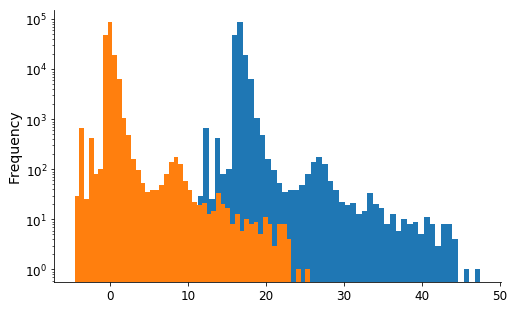

In [14]:
# Normalize the data

# Before
data[0].plot.hist(bins=50, logy=True);

data.iloc[:, 0:2806] = StandardScaler().fit_transform(data.iloc[:, 0:2806].values)

# After
data[0].plot.hist(bins=50, logy=True);

In [15]:
# Split the data

# This will work in scikit v19
# X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 0:2806], data["label"], shuffle=False)

# This will work in scikit v<19

split_factor = 0.8

split = round(split_factor*len(data))

train = data.iloc[:split]
X_train = train.iloc[:, 0:2806]
y_train = train["label"]

test = data.iloc[split:]
X_test = test.iloc[:, 0:2806]
y_test = test["label"]

print("Number of inliers in test set: %s" % sum((y_test == 0).values))
print("Number of anomalies in the test set: %s" % sum((y_test == 1).values))

Number of inliers in test set: 32078
Number of anomalies in the test set: 659


# Training the autoencoder

In [16]:
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense
from keras.layers.advanced_activations import PReLU
from keras.models import Model, load_model

Using TensorFlow backend.


In [17]:
# Train only on good

X_train = X_train[y_train == 0]
X_train = X_train.values
X_test = X_test.values

In [18]:
input_dim = X_train.shape[1]

In [19]:
# Define the model

input_layer = Input(shape=(input_dim, ))
prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
encoded = Dense(2000, kernel_regularizer=keras.regularizers.l1(10e-5))(input_layer)
encoded = prellll(encoded)

prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
encoded = Dense(1000, kernel_regularizer=keras.regularizers.l1(10e-5))(encoded)
encoded = prellll(encoded)

prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
encoded = Dense(500, kernel_regularizer=keras.regularizers.l1(10e-5))(encoded)
encoded = prellll(encoded)

prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
encoded = Dense(1000, kernel_regularizer=keras.regularizers.l1(10e-5))(encoded)
encoded = prellll(encoded)

prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
encoded = Dense(2000, kernel_regularizer=keras.regularizers.l1(10e-5))(encoded)
encoded = prellll(encoded)

prellll = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)
decoder = Dense(input_dim)(encoded)
decoder = prellll(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              5614000   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1000)              1000      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 500)               500       
__________

In [20]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

history = autoencoder.fit(X_train,
                          X_train,
                          epochs=8192,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.25,
                          verbose=2,
                          callbacks=[early_stopper, checkpoint_callback]).history

Train on 96921 samples, validate on 32308 samples
Epoch 1/8192
42s - loss: 8.9487 - val_loss: 1.4872
Epoch 2/8192
27s - loss: 0.6780 - val_loss: 0.6804
Epoch 3/8192
26s - loss: 0.5155 - val_loss: 0.6548
Epoch 4/8192
26s - loss: 0.5065 - val_loss: 0.6469
Epoch 5/8192
25s - loss: 0.5006 - val_loss: 0.6416
Epoch 6/8192
26s - loss: 0.4944 - val_loss: 0.6315
Epoch 7/8192
25s - loss: 0.4884 - val_loss: 0.6261
Epoch 8/8192
26s - loss: 0.4835 - val_loss: 0.6201
Epoch 9/8192
25s - loss: 0.4795 - val_loss: 0.6156
Epoch 10/8192
27s - loss: 0.4760 - val_loss: 0.6085
Epoch 11/8192
25s - loss: 0.4731 - val_loss: 0.6034
Epoch 12/8192
26s - loss: 0.4705 - val_loss: 0.6002
Epoch 13/8192
26s - loss: 0.4681 - val_loss: 0.5969
Epoch 14/8192
25s - loss: 0.4660 - val_loss: 0.5937
Epoch 15/8192
25s - loss: 0.4641 - val_loss: 0.5917
Epoch 16/8192
26s - loss: 0.4624 - val_loss: 0.5877
Epoch 17/8192
25s - loss: 0.4608 - val_loss: 0.5846
Epoch 18/8192
26s - loss: 0.4593 - val_loss: 0.5791
Epoch 19/8192
25s - los

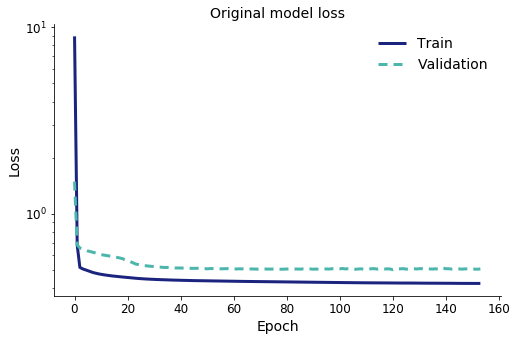

In [21]:
def plot_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][900], linewidth=3)
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Teal"][300], linewidth=3)
    plt.legend(["Train", "Validation"], loc="upper right", frameon=False)
    plt.yscale("log")
    plt.show();

plot_loss(history, "Original model loss")

In [22]:
# Reload saved model

autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [23]:
# Run predictions

predictions = autoencoder.predict(X_test)

# Calculating Mean Square of features

In [24]:
mean_square = np.mean(np.power(X_test, 2), axis=1)

# Evaluation

In [25]:
legend = [{"name": 'pf_jets', "start": 0, "end": 777, "color": color_palette["Indigo"][100]},
          {"name": 'cal_jet_mets', "start": 778, "end": 946, "color": color_palette["Indigo"][300]},
          {"name": 'pho', "start": 947, "end": 1283, "color": color_palette["Indigo"][500]},
          {"name": 'muons', "start": 1284, "end": 1788, "color": color_palette["Indigo"][700]},
          {"name": 'pf_jets2', "start": 1789, "end": 1894, "color": color_palette["Indigo"][900]},
          {"name": 'pf_mets', "start": 1895, "end": 1923, "color": color_palette["Indigo"][200]},
          {"name": 'nvtx', "start": 1924, "end": 1925, "color": color_palette["Indigo"][400]},
          {"name": 'cal_jet_mets2', "start": 1925, "end": 2037, "color": color_palette["Indigo"][600]},
          {"name": 'sc', "start": 2038, "end": 2129, "color": color_palette["Indigo"][800]},
          {"name": 'cc', "start": 2130, "end": 2172, "color": color_palette["Teal"][100]},
          {"name": 'pho2', "start": 2173, "end": 2369, "color": color_palette["Teal"][300]},
          {"name": 'muons2', "start": 2370, "end": 2476, "color": color_palette["Teal"][500]},
          {"name": 'ebs', "start": 2497, "end": 2707, "color": color_palette["Teal"][700]},
          {"name": 'hbhef', "start": 2708, "end": 2771, "color": color_palette["Teal"][900]},
          {"name": 'presh', "start": 2772, "end": 2810, "color": color_palette["Teal"][400]}]

In [67]:
# Get error

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

scores = get_error_df(X_test, predictions, mode="topn")

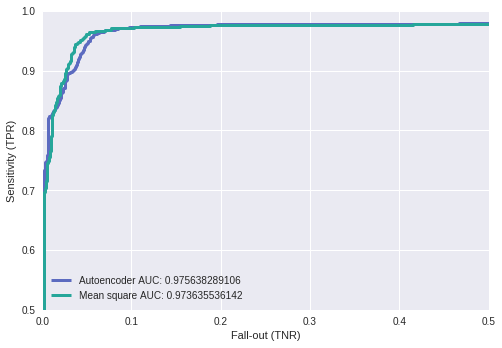

In [68]:
#Make ROC_curve

from sklearn.metrics import auc, roc_curve                            

def get_roc_curve(label, score, legend_label):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    fpr, tpr, thresholds = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr,
             tpr,
             linewidth=3,
             color=color_palette["Indigo"][400],
             linestyle=line_styles[0],
             label=("Autoencoder AUC: %s" % (roc_auc)))
    
    fpr_ms, tpr_ms, thresholds_ms = roc_curve(label, mean_square)
    roc_auc_ms = auc(fpr_ms, tpr_ms)
    
    plt.plot(fpr_ms,
             tpr_ms,
             linewidth=3,
             color=color_palette["Teal"][400],
             linestyle=line_styles[0],
             label=("Mean square AUC: %s" % (roc_auc_ms)))

    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0.5, 1])
    plt.xlim([0, 0.5])
    plt.show();
    
get_roc_curve(y_test.values, scores, "Original autoencoder vs mean square")

In [28]:
from sklearn.metrics import accuracy_score

def find_optimal_cutoff(y_true, scores):
    step_factor = 1000
    max_acc = 0
    best_threshold = None
    for threshold in tqdm(np.geomspace(min(scores), max(scores), step_factor)):
        y_pred = [1 if e > threshold else 0 for e in scores]
        acc = accuracy_score(y_true, y_pred)
        if acc > max_acc:
            max_acc = acc
            best_threshold = threshold
    return best_threshold, max_acc

ae_cutoff, ae_acc = find_optimal_cutoff(y_test.values, scores)
ms_cutoff, ms_acc = find_optimal_cutoff(y_test.values, mean_square)

100%|██████████| 1000/1000 [00:10<00:00, 93.05it/s]


In [69]:
# Calculate F1 score (2 * (precision * recall) / (precision + recall))

from sklearn.metrics import f1_score

y_pred_ae = [1 if e > ae_cutoff else 0 for e in scores]
ae_f1_score = f1_score(y_test.values, y_pred_ae)

y_pred_ms = [1 if e > ms_cutoff else 0 for e in mean_square]
ms_f1_score = f1_score(y_test.values, y_pred_ms)

print("Autoencoder F1 score:", ae_f1_score)
print("Mean square F1 score:", ms_f1_score)

Autoencoder F1 score: 0.78955954323
Mean square F1 score: 0.770408163265


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

LABELS = ["Normal", "Anomalous"]

def conf_matrix(scores, threshold, title):
    print("Threshold:", threshold)
    y_pred = [1 if e > threshold else 0 for e in scores]
    conf_matrix = confusion_matrix(y_test.values, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_test.values, y_pred)
    class_imbal = np.mean(1 - y_test.values)
    adj_acc = (acc - class_imbal) / (1 - class_imbal)

    print("Adjusted accuracy:", adj_acc)

Threshold: 187.999948068


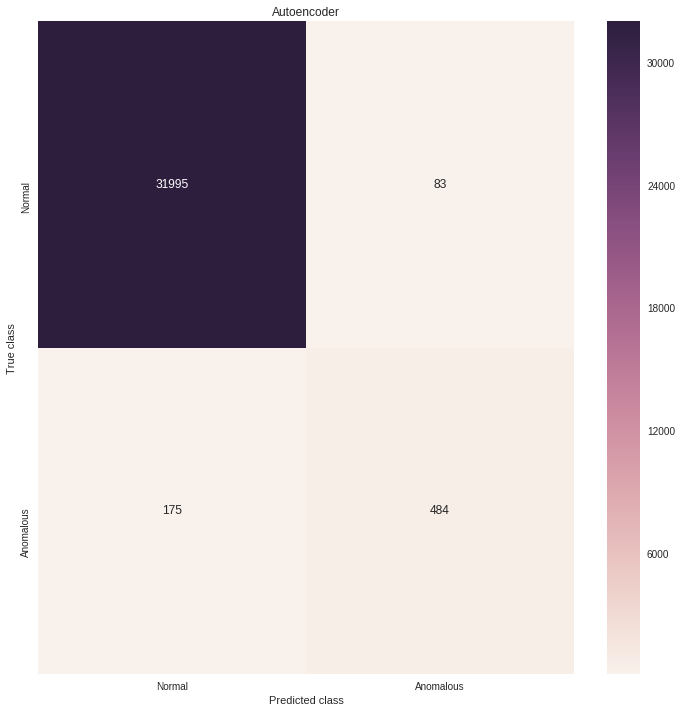

Adjusted accuracy: 0.608497723824


In [31]:
conf_matrix(scores, ae_cutoff, "Autoencoder")

Threshold: 15.7438743917


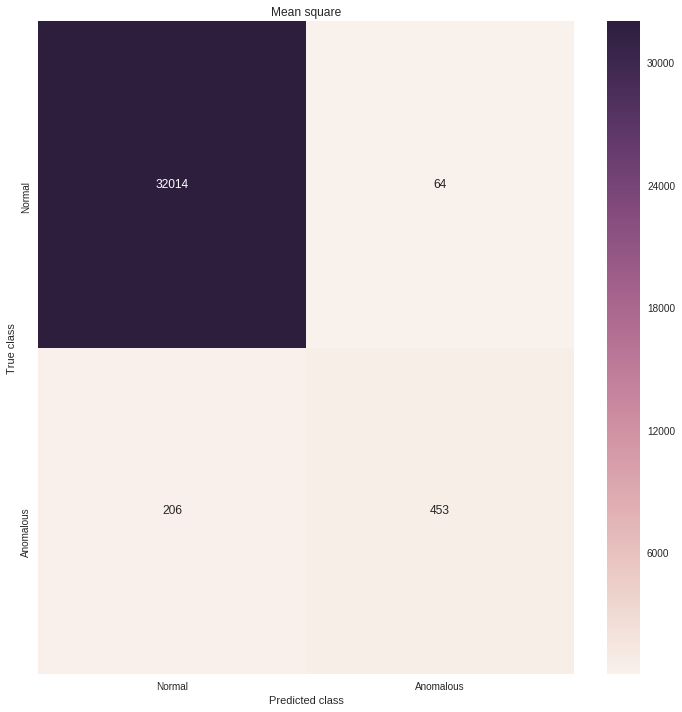

Adjusted accuracy: 0.59028831563


In [86]:
conf_matrix(mean_square, ms_cutoff, "Mean square")

In [79]:
# Plot lumi vs error
def plot_lumi_error(scores, threshold=None):
    fig, ax = plt.subplots()

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
             scores[y_test == 0],
             color=color_palette["Teal"][300],
             linestyle='',
             ms=2,
             marker='o',
             label="Outlier")

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
             scores[y_test == 1],
             color=color_palette["Indigo"][700],
             linestyle='',
             ms=2,
             marker='o',
             label="Inlier")

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    
    ax.set_yscale("log")
    plt.ylabel("Score")
    plt.xlabel("Lumisection #")
    plt.show();

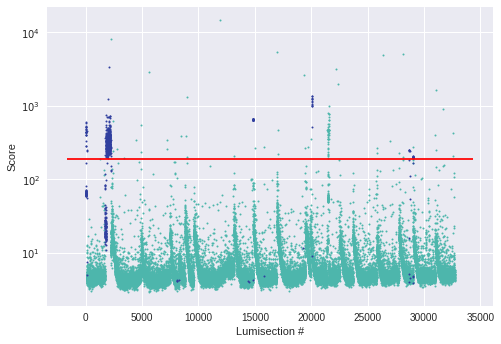

In [80]:
# Plot lumi vs error AE
plot_lumi_error(scores, ae_cutoff)

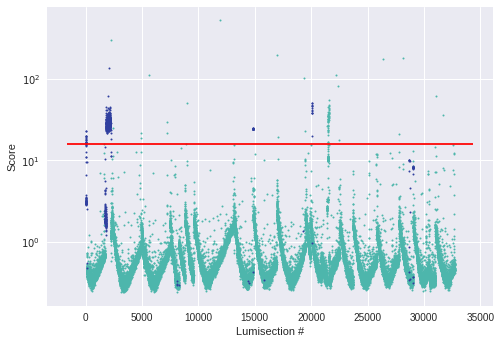

In [81]:
# Plot lumi vs error MS
plot_lumi_error(mean_square, ms_cutoff)

In [39]:
# Plot something over features
def plot_over_features(array, label, y_low=-20, y_high=20):
    features = [i for i in range(array.shape[0])]

    for l in legend:
        plt.plot(features[l["start"]:l["end"]],
                 array[l["start"]:l["end"]],
                 color=l["color"])

    plt.ylabel(label)
#     plt.ylim([y_low, y_high])
    plt.xticks([l["start"] for l in legend], [l["name"] for l in legend], rotation='vertical')
    plt.show();

Label: 1


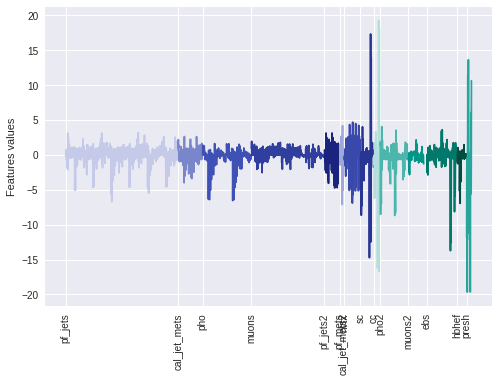

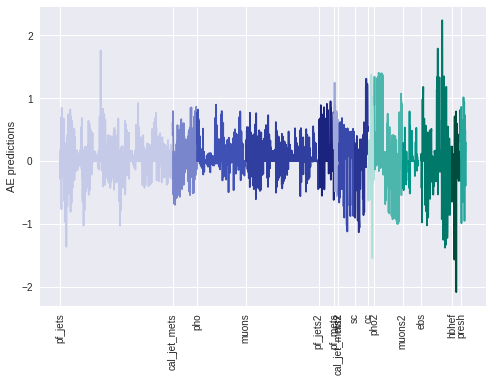

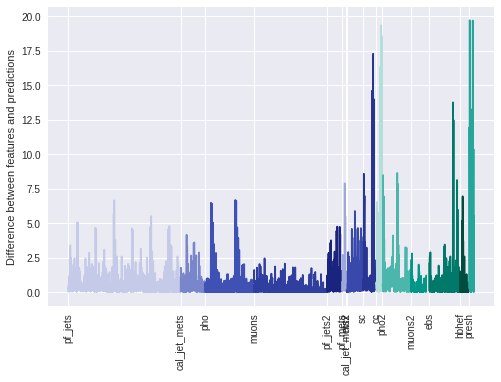

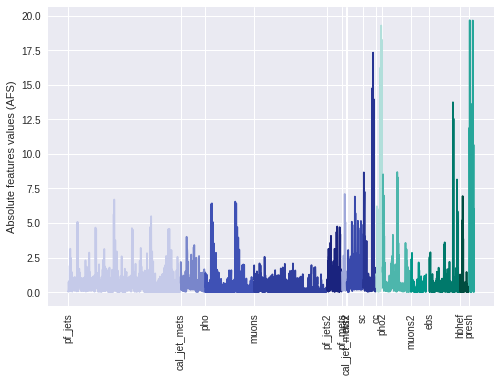

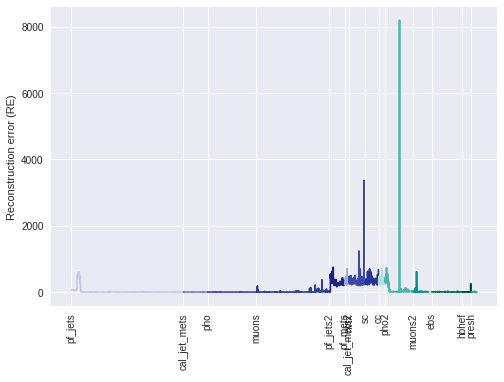

In [43]:
# Choose lumisection
INDEX = 1

# Print label
print("Label:", y_test.values[0])

plot_over_features(X_test[INDEX], "Features values")
plot_over_features(predictions[INDEX], "AE predictions")

reco_error = abs(X_test[INDEX] - predictions[INDEX])
plot_over_features(reco_error, "Difference between features and predictions", 0)

abs_features = abs(X_test[INDEX])
plot_over_features(abs_features, "Absolute features values (AFS)", 0)

plot_over_features(scores, "Reconstruction error (RE)", 0)

# plot_over_features(abs(scores - abs_features), "Features - AFS", 0)